# Utility

In [1]:
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu  # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt

import numba
from joblib import Parallel, delayed  # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation
import tempfile
import gmsh
import meshio
import itertools
import shutil  # file copying
import networkx as nx # graph representation
import os

from lxml import etree
from matplotlib.colors import to_hex

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################
from robot_utils import *
import robot_utils
help(robot_utils)

######################################################
robot_folder = "../../mesh/4dof/"

open3d :0.12.0
trimesh:3.9.8
numba  :0.53.0
Help on module robot_utils:

NAME
    robot_utils

CLASSES
    builtins.dict(builtins.object)
        Unit
        VolumeMesh
    builtins.object
        Joint
        URDF
    networkx.classes.ordered.OrderedDiGraph(networkx.classes.digraph.DiGraph)
        RobotDescription
    
    class Joint(builtins.object)
     |  Joint(left, right, anchor, left_coord, right_coord, num_spring_per_mass=20, axis=None)
     |  
     |  Methods defined here:
     |  
     |  __init__(s, left, right, anchor, left_coord, right_coord, num_spring_per_mass=20, axis=None)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  __repr__(s)
     |      Return repr(self).
     |  
     |  toDict(s)
     |  
     |  tolist(s)
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if define

# Leg generation

Only need to run once

In [2]:
import cadquery as cq
from math import atan2,pi

leg_d0 = 0.05+2 # length of first segment, 2.2 is the thickness of the coupler
leg_d1 = 120  # length of last segment
# leg_d1 = 240  # length of last segment
leg_r0 = 38   # radius of rotation of mid segment

leg_r1 = 32   # radius of the first segment
leg_r2 = leg_r1   # radius of the end at the second segment
leg_r3 = 24   # radius at the end of the last segment

leg_a0_deg = 90
leg_a0 = leg_a0_deg*pi/180. # mid section rotation angle

taper_angle = atan2(leg_r2-leg_r3,leg_d1) # taper angle [rad] of last section

leg_fillet = 24 # fillet at the end of the leg
leg_innercut_ratio =0.5

def makeLeg(d0 = leg_d0,# length of first segment
#             joint_overlap = joint_overlap, #overlap of the joint
            d1 = leg_d1,# length of last segment
            r0 = leg_r0,# radius of rotation of mid segment
            r1 = leg_r1,# radius of the first segment
            taper = taper_angle,# taper angle [rad] of last section
            r_fillet = leg_fillet,# fillet at last section
            innercut_ratio = leg_innercut_ratio
            ):
#     path = cq.Workplane("XY").center(0, 0).line(d0,0)\
#        .radiusArc((r0+leg_d0,r0),-r0)
    path = cq.Workplane("XY").center(0, 0).radiusArc((r0,r0),-r0)
    result = cq.Workplane("YZ").circle(r1).sweep(path) # first+mid section
#     result = result.faces("<X").circle(r1).extrude(-joint_overlap) # joint overlap section
    result = result.faces(">Y").workplane(centerOption="CenterOfMass").tag("midplane")\
        .circle(r1).extrude(d1,taper=taper*180./pi)\
        .faces(">Y").edges().fillet(r_fillet) # last section fillet
    result = result.workplaneFromTagged("midplane")\
        .circle(r1*innercut_ratio).cutBlind(d1+1,taper=taper*180./pi)
    return result

leg = makeLeg()
# show_object(leg)
cq.exporters.export(leg,"../../mesh/4dof/leg_simplified.step")
# cq.exporters.export(leg,"../../mesh/leg_simplified.stl")

In [2]:
########## discretization parameters ##############
# radius_poisson = float(10) # radius for the poisson sampling
radius_poisson = float(16) # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.0
min_radius = radius_poisson*0.6
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
max_nn = int(28)
print(radius_knn)

half_joint_overlap = radius_poisson * 0
joint_overlap = half_joint_overlap*2
print(f"joint_overlap:{joint_overlap}")

# general argument
gmsh_args = [
        ("Mesh.Algorithm", 6), # 2D mesh algorithm (1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay, 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms)
        ("Mesh.Algorithm3D", 10), # 3D mesh algorithm (1: Delaunay, 3: Initial mesh only, 4: Frontal, 7: MMG3D, 9: R-tree, 10: HXT)
        ("Mesh.MeshSizeExtendFromBoundary", 0),# Extend computation of mesh element sizes from the boundaries into the interior (for 3D Delaunay, use 1: longest or 2: shortest surface edge length)
        ("Mesh.MeshSizeFromPoints", 0),# Compute mesh element sizes from values given at geometry points, defualt:1
        ("Mesh.MeshSizeFromCurvature", 0),# Automatically compute mesh element sizes from curvature,defult:0
        ("Mesh.OptimizeNetgen",0), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
        ("Mesh.OptimizeThreshold",0.5), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
#         ("Mesh.AllowSwapAngle",30), # Threshold angle (in degrees) between faces normals under which we allow an edge swap
        ("Mesh.VolumeEdges",1), # Display edges of volume mesh
        ("Mesh.VolumeFaces",0), # Display faces of volume mesh
        ("Mesh.SurfaceFaces",1), # Display faces of surface mesh?
        ("Mesh.Smoothing",8), # Number of smoothing steps applied to the final mesh
#         ("Mesh.SmoothNormals",0), # Smooth the mesh normals? default 0
        ("Mesh.Binary",1), # Write mesh files in binary format (if possible)
        ("Mesh.MinimumCirclePoints",0), # Minimum number of nodes used to mesh circles and ellipses
        ("Mesh.MinimumCurvePoints",0), # Minimum number of points used to mesh curves other than lines, circles and ellipses
        ("Mesh.MinimumElementsPerTwoPi",0), # Minimum number of elements per 2 * Pi radians when the mesh size is adapted to the curvature    
        ("Mesh.RefineSteps",20), # Number of refinement steps in the MeshAdapt-based 2D algorithms, default:10
    
#         ("Geometry.Tolerance",radius_poisson*0.5),# Geometrical tolerance,default:1e-8
        ("Geometry.OCCFixDegenerated",1), # Fix degenerated edges/faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
        ("Geometry.OCCFixSmallEdges",1), # Fix small edges when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
        ("Geometry.OCCFixSmallFaces",1), # Fix small faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
#         ("Geometry.OCCSewFaces",1), # Sew faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel
#         ("Geometry.OCCBoundsUseStl",1), # Use STL mesh for computing bounds of OpenCASCADE shapes (more accurate, but slower)

        ("General.Verbosity",0), # Level of information printed during processing (0: no information), default:5
        ("General.Terminal",0), # Should information be printed on the terminal (if available)
#         ("Mesh.RandomSeed",0), # Seed of pseudo-random number generator
#         ("Mesh.QualitySup",0.5), # Only display elements whose quality measure is smaller than QualitySup
]

# 2D specific argument
gmsh_args_2d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.25),
        ("Mesh.MeshSizeMax", radius_poisson*1.25),
] 

# 3D specific argument
gmsh_args_3d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.0),
        ("Mesh.MeshSizeMax", radius_poisson*1.0),
]

gmsh_args = gmsh_args+gmsh_args_2d # combined

# # # discretize body
# # in_file_name: str = "../../mesh/soft_body_simplified.step"
# # out_file_name: str = "../../mesh/soft_body_simplified.msh"
# in_file_name: str = "../../mesh/leg_simplified.step"
# out_file_name: str = "../../mesh/leg_simplified.msh"
# vmesh,_= generateGmsh(in_file_name,out_file_name,dim=3,gui=True)
# # print(vmesh)
# vmeshSummary(vmesh)

27.712812921102035
joint_overlap:0.0


# Leg discretization

Only need to run once

# vertices          = 177
# surface triangle  = 336
# tetra             = 500
# unique tetra edges= 844
# unique face edges = 504
COM                 =  [32.943 61.472  0.244]
COM norm            = 69.743
mean edge length    = 19.48


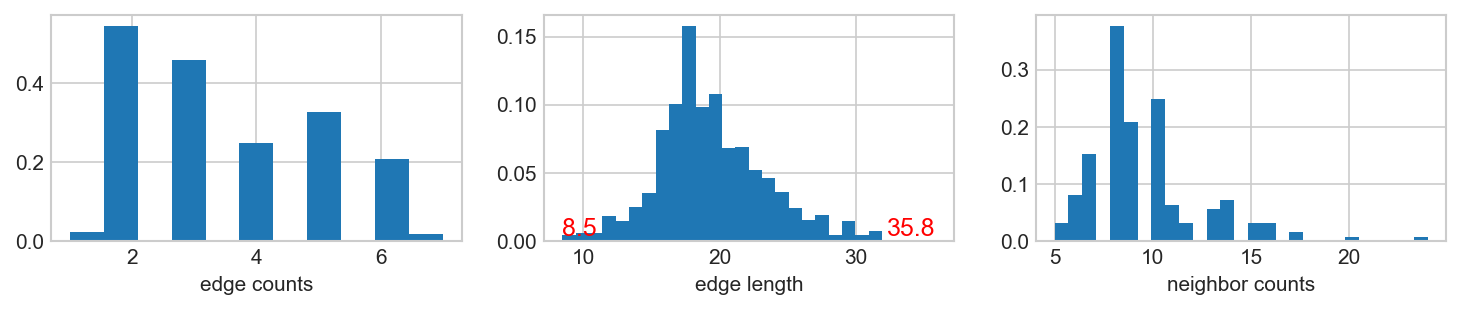

In [3]:
in_file_name: str = robot_folder+"leg_simplified.step"
out_file_name: str = robot_folder+"leg_simplified.msh"

vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,dim=3,gui=False)
# # optimze vertices location
# n_jobs = int(multiprocessing.cpu_count()*0.2)
# total_jobs = int(n_jobs*1)
# # print(n_jobs,total_jobs)
# result = Parallel(n_jobs=n_jobs)(delayed(generateGmsh)(in_file_name,None) for i in range(total_jobs))
# mse_list = [np.linalg.norm(np.mean(vmesh.points[vmesh.points[:,0]<=0],axis=0)[1:]) for vmesh,_ in result]
# vmesh,best_vmesh_name = result[np.argmin(mse_list)]
# shutil.copyfile(best_vmesh_name,out_file_name) # copy the temp file to the out file
vmeshSummary(vmesh)

# with np.printoptions(precision=3, suppress=True):
#     print("COM at 1st section:",np.mean(vmesh.points[vmesh.points[:,0]<=0],axis=0))    

# Body discretization

Only need to run once

# vertices          = 1074
# surface triangle  = 1982
# tetra             = 3390
# unique tetra edges= 5451
# unique face edges = 2973
COM                 =  [ 0.023  0.236 -0.009]
COM norm            = 0.237
mean edge length    = 19.44


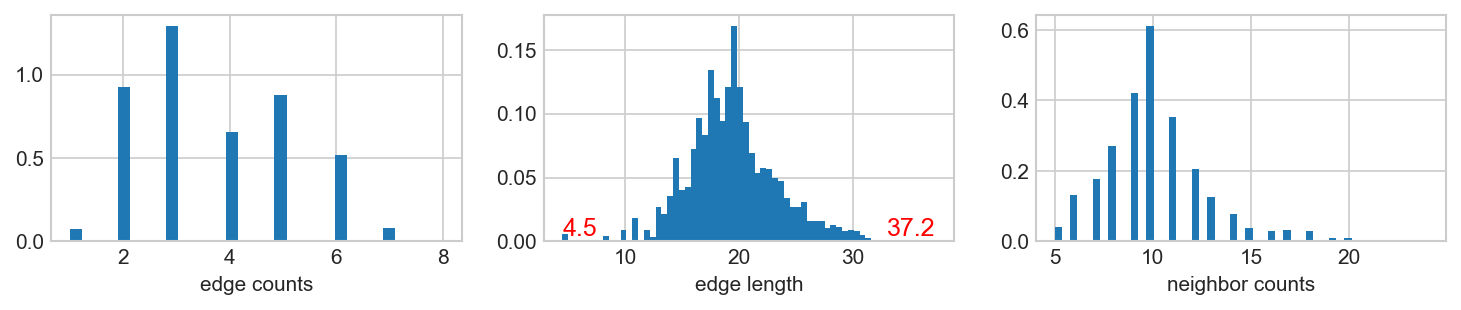

In [4]:
# discretize body
in_file_name: str = robot_folder+"soft_body_simplified.step"
out_file_name: str = robot_folder+"soft_body_simplified.msh"
vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,gui=False)
# print(vmesh)
vmeshSummary(vmesh)

### load descritized leg

In [3]:
# %load_ext line_profiler
# %lprun -f discretize vmesh_leg,mesh_leg,pcd_leg,lsd_leg,nsd_leg = discretize(msh_file="../../mesh/leg_simplified.msh")
# transform = np.array([
#     [0, 0,1],
#     [0, 1,0],
#     [1,0,0],
# ])

vmd_leg = VolumeMesh.fromGmsh(
    msh_file=robot_folder+"leg_simplified.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4))
    
# vmesh_leg,mesh_leg,pcd_leg,lsd_leg,nsd_leg = discretize(
#     msh_file="../../mesh/leg_simplified.msh",transform = transform)

In [21]:
# new_vertices = equidistantCylinder(
#     r=radius_poisson*2*1.2, h=radius_poisson*4*1.2, dr=radius_poisson*1.2)
# new_vertices = applyTransform(new_vertices, np.array(
#     [[0, 0, 1],
#      [1, 0, 0],
#      [0, 1, 0]]))
# vmd_leg.appendVertices(
#     new_vertices, min_radius=0, max_radius=radius_knn, max_nn=max_nn)
# o3dShow([vmd_leg.pcd(), vmd_leg.lsd()])

# vmd = vmd_leg.copy()
# cylinder_spec = dict(center=(0, 0, 0), axis=(1, 0, 0), radius=25, height=30)
# cylinder, _ = generateGmsh(gmshGeoFcn=gmshGeoAddCylinder, gmsh_geo_kwargs=cylinder_spec,
#                            gmsh_args=gmsh_args, gmsh_args_3d=gmsh_args_3d, gui=False)
# vmd_cylinder = VolumeMesh.fromGmsh(
#     cylinder, min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn)
# vmd = vmd.combine(vmd_cylinder, min_radius=min_radius,
#               max_radius=radius_knn, max_nn=max_nn,keep_triangles=True)
# o3dShow([vmd.pcd(), vmd.lsd(), vmd.o3dMesh()])
# vmd.describe()
# np.linalg.norm(vertices[lines][:,1]-vertices[lines][:,0],axis=1)

### load descritized body

In [4]:
transform = np.array([[0, 0, 1, 0],
                      [1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 0, 1]], dtype=np.float64)
# x: back->front
# y: right->left
# z: down->top
vmd_body = VolumeMesh.fromGmsh(
    msh_file=robot_folder+"soft_body_simplified.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=transform)

In [23]:
# vmd = VolumeMesh(vmd_leg.vertices,vmd_leg.lines,vmd_leg.triangles).copy(cmap ='pink')
# o3dShow([vmd.lsd,vmd.pcd])

# Assemble the parts

In [5]:
############################ defineing joints geometry
rot_ang = 10.0/189.*np.pi
cylinder_len = 103
dx = 260.0/2 + cylinder_len*np.sin(rot_ang)
dy = 0.0 + cylinder_len*np.cos(rot_ang)

########################################################
t_axial = translation((0,0,cylinder_len-half_joint_overlap)) # translate along cylinder
t_zrot = axisAngleRotation((0,0,1),np.pi)

t0 = translation((+dx,+dy,0)).dot(axisAngleRotation((0, 0, 1),-rot_ang+np.pi/2))# front left
t1 = translation((-dx,+dy,0)).dot(axisAngleRotation((0, 0, 1),+rot_ang+np.pi/2))# back left
t2 = translation((-dx,-dy,0)).dot(axisAngleRotation((0, 0, 1),-rot_ang-np.pi/2))# back right
t3 = translation((+dx,-dy,0)).dot(axisAngleRotation((0, 0, 1),+rot_ang-np.pi/2))# front right

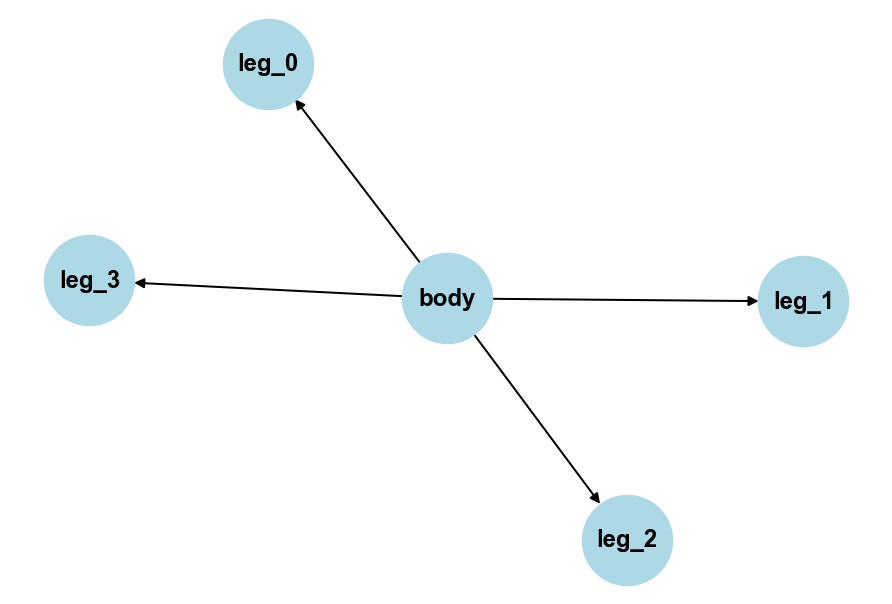

In [6]:
graph = RobotDescription(unit_dict={"length":"mm"})
graph.add_nodes_from([
    ("body", {"vmd": vmd_body.copy(),"color":(1,0,0,1),"density":600}),  # main_body
    ("leg_0", {"vmd": vmd_leg.copy(cmap ='spring'),"color":(0,1,0,1),"density":400}),  # front left
    ("leg_1", {"vmd": vmd_leg.copy(cmap ='summer'),"color":(0,1,0,1),"density":400}),  # back left
    ("leg_2", {"vmd": vmd_leg.copy(cmap ='autumn'),"color":(0,0,1,1),"density":400}),  # back right
    ("leg_3", {"vmd": vmd_leg.copy(cmap ='winter'),"color":(0,0,1,1),"density":400}),  # front right
#     ("leg_4", {"vmd": vmd_leg.copy(cmap ='winter'),"color":(0,0,1,1),"density":400}),  # front right
],
    transform = np.eye(4),
    density = 400., # kg/m^3
    color = np.array((1,1,1,1)) # white
)

graph.add_edges_from((
    ("body", "leg_0", {"order":0,"transform": t0, "joint_pos": 0}),
    ("body", "leg_1", {"order":1,"transform": t1, "joint_pos": 0}),
    ("body", "leg_2", {"order":2,"transform": t2, "joint_pos": 0}),
    ("body", "leg_3", {"order":3,"transform": t3, "joint_pos": 0}),
#     ("body", "leg_4", {"transform": t3, "joint_pos": np.pi/2}),
),
    transform=np.eye(4),
    joint_type="continuous",
    joint_pos=0, 
    axis=(1, 0, 0),
    limit = { # units must be SI here
        "effort":5, # torque, [Nm]
        "velocity":round(487/60*2*np.pi) # speed [rad/s]
    }
)
# create coordinate in body space
graph.createCoordinateOXYZ(radius=15)

nx.draw(graph,nx.spring_layout(graph), with_labels=True, font_weight='bold',node_size=2000,node_color="lightblue")
################## computed value ###################################
graph.updateWorldTransform()
# list(nx.edge_bfs(graph))



graph.joint_pos = np.array([-np.pi/2,-np.pi/2,-np.pi/2,-np.pi/2])
# graph.joint_pos = np.array([np.pi/8, np.pi/8, np.pi/8, np.pi/8])

In [7]:
world_space_pcds = [o3d.geometry.PointCloud(graph.nodes[n]["vmd"].pcd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_lsd = [o3d.geometry.LineSet(graph.nodes[n]["vmd"].lsd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_o3dMesh = [o3d.geometry.TriangleMesh(graph.nodes[n]["vmd"].o3dMesh()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]



link_coordinate_frames = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.nodes[n]["world_transform"])for n in graph.nodes]

joint_coordiate_frams = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.edges[e]["world_transform"])for e in graph.edges]

# o3dShow(world_space_pcds+world_space_lsd+link_coordinate_frames+joint_coordiate_frams + [coord_frame])

###############################################
discretization_opt = dict(
    min_radius=min_radius, 
    max_radius=radius_knn, 
    max_nn=max_nn,
    joint_radius = 25,
    joint_height = 50,
    joint_sections = 50, # number of sections of the joint cylinder mesh
    gmsh_args=gmsh_args,
    gmsh_args_3d=gmsh_args_3d
)



graph = graph.makeJoint(opt=discretization_opt)
########################################

joint_cylinders = [o3d.geometry.TriangleMesh(graph.edges[e]["cylinder_parent"].o3dMesh()).transform(
    graph.nodes[e[0]]["world_transform"]) for e in graph.edges]
# o3dShow(world_space_pcds[0:]+world_space_lsd[0:]+world_space_o3dMesh[0:]+joint_cylinders[0:])#+link_coordinate_frames+joint_coordiate_frams)
o3dShow(world_space_pcds[0:]+world_space_lsd[0:]+joint_cylinders[0:])#+link_coordinate_frames+joint_coordiate_frams)

# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(vertices),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
# o3dShow([robot_lsd]+joint_cylinders[0:])

('body', 'leg_0'):45,45
('body', 'leg_1'):45,45
('body', 'leg_2'):45,45
('body', 'leg_3'):45,45


In [8]:
# saving
import pickle
path = robot_folder+"robot.pickle"
with open(path,"wb") as f:
    pickle.dump(graph,f)

In [9]:
# loading
import pickle
path = robot_folder+"robot.pickle"
with open(path,"rb") as f:
    graph = pickle.load(f)

# create spring-mass representation

dict_id2node=
{0: 'body', 1: 'leg_0', 2: 'leg_1', 3: 'leg_2', 4: 'leg_3'}
dict_id2edge=
{0: ('body', 'leg_0'), 1: ('body', 'leg_1'), 2: ('body', 'leg_2'), 3: ('body', 'leg_3')}
----------------------------------------
id_vertices labels:
(0, 'body')
(1237, 'leg_0')
(1456, 'leg_1')
(1675, 'leg_2')
(1894, 'leg_3')
(2113, 'anchor')
(2121, 'coord')
(2184, 'end')
----------------------------------------
id_lines labels:
(0, "('body', 'leg_0')")
(8983, "('body', 'leg_1')")
(10541, "('body', 'leg_2')")
(12099, "('body', 'leg_3')")
(13657, 'anchor_lines')
(15215, 'rot_springs')
(15219, 'fri_springs')
(15939, 'coord_self_lines')
(19471, 'coord_attach_lines')
(19660, 'end')
----------------------------------------


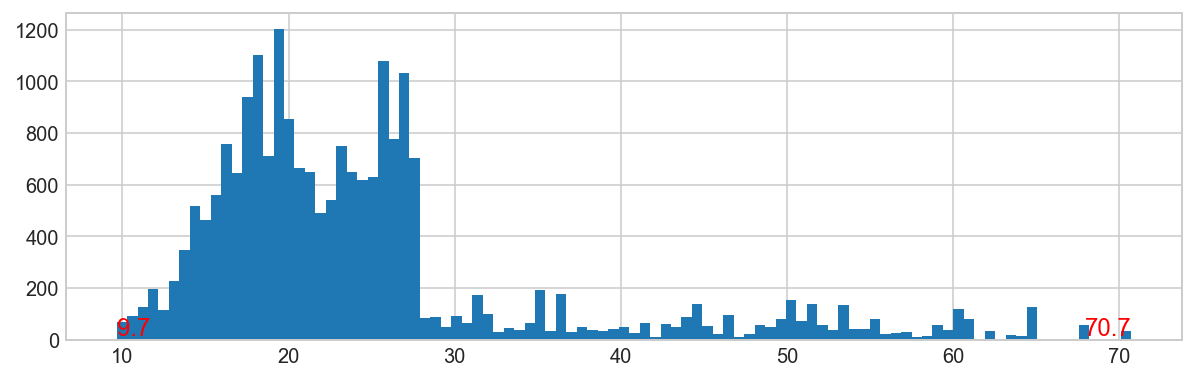

In [10]:
# number of attachment lines per point in the attached coordinates
num_attach_per_coord = 25

# num of friction spring (spring connecting the two parts of the joint) per mass
num_fri_spring_per_mass = 20

######################################################################
dict_id2node = dict(enumerate(graph.nodes)) # dict of index to node
dict_node2id = dict(zip(graph.nodes, range(len(graph.nodes)))) # dict of node to index
print(f"dict_id2node=\n{dict_id2node}")
dict_id2edge = dict(enumerate(graph.edges)) # dict of index to edges
dict_edge2id = dict(zip(graph.edges, range(len(graph.edges))))
print(f"dict_id2edge=\n{dict_id2edge}","-"*40, sep = "\n")


graph.updateWorldTransform()

# ############################# transform vertices local to world ############
part_vertices = [applyTransform(graph.nodes[n]["vmd"].vertices,
                                graph.nodes[n]["world_transform"]) for n in graph.nodes]
anchor_vertices = [applyTransform(graph.edges[e]['anchor'],
                                  graph.edges[e]["world_transform"]) for e in graph.orderedEdges]
part_coord_vertices = [applyTransform(graph.nodes[n]['coord'],
                                      graph.nodes[n]["world_transform"]) for n in graph.nodes]
joint_coord_vertices = [applyTransform(graph.edges[e]['coord'],
                                       graph.edges[e]["world_transform"]) for e in graph.orderedEdges]

vertices = part_vertices + [
    np.vstack(anchor_vertices),
    np.vstack(part_coord_vertices+joint_coord_vertices)]
id_vertices = np.hstack(([0], np.cumsum([len(v) for v in vertices])))
vertices = np.vstack(vertices) # stack to single array [nx3]
#                            part names,        anchor,   choor,  end
id_vertices_label = list(map(str,graph.nodes))+["anchor","coord","end"]
# colors of the vertices
part_colors = np.vstack([graph.nodes[n]["vmd"]["vertices_color"] for n in graph.nodes])
colors = np.zeros((len(vertices), 3))
colors[:len(part_colors)] = part_colors

###################################################################
part_len = [len(v) for v in part_vertices]
anchor_len = [len(v) for v in anchor_vertices]
part_coord_len = [len(v) for v in part_coord_vertices]
joint_coord_len = [len(v) for v in joint_coord_vertices]
# vertex ids
vid_part = np.hstack(([0], np.cumsum(part_len)))  # vertex id part
vid_anchor = np.hstack(([0], np.cumsum(anchor_len))) + vid_part[-1]  # vertex id anchor
vid_part_coord = np.hstack(([0], np.cumsum(part_coord_len))) + vid_anchor[-1] # vertex id part coordinate
vid_joint_coord = np.hstack(([0], np.cumsum(joint_coord_len))) + vid_part_coord[-1] # vertex id joint coordinate

for k, n in enumerate(graph.nodes):
    graph.nodes[n]["vertex_start_id"] = vid_part[k]
    graph.nodes[n]["coord_start_id"] = vid_part_coord[k]
for k, e in enumerate(graph.orderedEdges):
    graph.edges[e]["coord_start_id"] = vid_joint_coord[k]
    graph.edges[e]["anchor_start_id"] = vid_anchor[k]
############################################################
part_triangles = [graph.nodes[n]["vmd"].triangles +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

triangles = np.vstack(part_triangles)
###############################################################
# part surfaces
part_surface_id = np.unique(triangles)
is_surface = np.zeros(len(vertices), dtype=bool)
is_surface[part_surface_id] = True
###############################################################
# lines
part_lines = [graph.nodes[n]["vmd"].lines +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

anchor_lines = [(graph.edges[e]["anchor_start_id"],
                 graph.edges[e]["anchor_start_id"]+1) for e in graph.orderedEdges]

part_coord_self_lines = [graph.nodes[n]["coord_start_id"] +
                         graph.nodes[n]["coord_self_lines"] for n in graph.nodes]
joint_coord_self_lines = [graph.edges[e]["coord_start_id"] +
                          graph.edges[e]["coord_self_lines"] for e in graph.orderedEdges]


# connecting coordinate to the body parts
part_coord_attach_lines = []
for k, n in enumerate(graph.nodes):
    part_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[k],
                  right_vertices=part_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[k],
                  right_id_start=vid_part_coord[k]))

# connecting coordinate to the joint-parent
joint_coord_attach_lines = []
for k, e in enumerate(graph.orderedEdges):
    parent_id = dict_node2id[e[0]]
    joint_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[parent_id],  # parent vertices
                  right_vertices=joint_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[parent_id],
                  right_id_start=vid_joint_coord[k]))


joints = []

for k, e in enumerate(graph.orderedEdges):
    edge = graph.edges[e]
    parent = e[0]
    child = e[1]
    parent_id = dict_node2id[e[0]]
    child_id = dict_node2id[e[1]]
    joint_k = Joint(
        left=edge["id_joint_parent"]+vid_part[parent_id],
        right=edge["id_joint_child"]+vid_part[child_id],
        anchor=anchor_lines[k],
        left_coord=edge["coord_start_id"],
        right_coord=graph.nodes[child]["coord_start_id"],
        num_spring_per_mass = num_fri_spring_per_mass,
        axis=edge["axis"]
    )
    lines_length = np.linalg.norm(vertices[joint_k.fri_spring[:, 0]] -
                                  vertices[joint_k.fri_spring[:, 1]], axis=1)
    joint_k.fri_spring = joint_k.fri_spring[lines_length > min_radius]
    joints.append(joint_k)

rot_springs = [j.rot_spring for j in joints]
fri_springs = [j.fri_spring for j in joints]

# lines:
# parts_lines = part_k_lines for k in range(#nodes)
# anchors_lines
# oxyz_self_springs
# oxyz_anchor_springs
# rotation springs
# resetable friction springs

coord_self_lines = part_coord_self_lines+joint_coord_self_lines
coord_attach_lines = part_coord_attach_lines+joint_coord_attach_lines

lines = part_lines + [
    np.vstack(anchor_lines),
    np.vstack(rot_springs),
    np.vstack(fri_springs),
    np.vstack(coord_self_lines),
    np.vstack(coord_attach_lines)]

# start, end of respective lines
id_lines = np.hstack(([0], np.cumsum([len(v) for v in lines])))

# labels for the id_lines
id_lines_label = list(map(str, graph.orderedEdges)) + [
    "anchor_lines",
    "rot_springs",
    "fri_springs",
    "coord_self_lines",
    "coord_attach_lines",
    "end"]

lines = np.vstack(lines) # stack to single array [nx2]

# whether the springs has surface end-points
lines_is_surface = np.bitwise_or.reduce(np.isin(lines,part_surface_id),1)

########################## print info #################################################
# print(f"id_vertices={id_vertices}")
print("id_vertices labels:",*zip(id_vertices,id_vertices_label),"-"*40, sep = "\n")
# print(f"id_lines={id_lines}")
print("id_lines labels:",*zip(id_lines,id_lines_label),"-"*40, sep = "\n")

lines_length = np.linalg.norm(vertices[lines[:,0]] - vertices[lines[:,1]],axis=1)
plt.figure(figsize=(10,3))
n,bins,_ =plt.hist(lines_length,bins="auto")
plt.text(bins[0],0,f"{bins[0]:.1f}",ha="left",va="bottom",fontsize="large",color='r')
plt.text(bins[-1],0,f"{bins[-1]:.1f}",ha="right",va="bottom",fontsize="large",color='r')

plt.show()

In [19]:
# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(vertices),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))

# o3dShow(robot_lsd)

# robot_triangles = o3d.geometry.TriangleMesh(
#     o3d.utility.Vector3dVector(vertices),
#     o3d.utility.Vector3iVector(triangles))
# robot_triangles.compute_triangle_normals()
# robot_triangles.vertex_colors =  o3d.utility.Vector3dVector(colors)
# o3dShow(robot_triangles)

In [12]:
# export
xyz_all_trans = vertices.copy()
min_bound = xyz_all_trans.min(axis=0)
# transoformed ofset scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+0]))/1000

joints_list = [joint.toDict() for joint in joints]
data = {
    "radius_poisson":radius_poisson*1e-3,# convert to m
    "vertices":xyz_all_trans.tolist(),
    "edges":lines.tolist(),
    "triangles":triangles.tolist(),
    "is_surface":is_surface.tolist(),
    "id_vertices":id_vertices.tolist(),
    "id_edges":id_lines.tolist(),
    "colors":colors.tolist(),
    "joints":joints_list,
}


print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))
print(xyz_all_trans.shape)
print(lines.shape)


# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(xyz_all_trans),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
# o3dShow([robot_lsd,o3d.geometry.TriangleMesh.create_coordinate_frame(
#     size=0.1, origin=[0, 0, 0])])

# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack
# Write msgpack file
with open('../flexipod_4dof.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)
    
# # Read msgpack file
# with open('../data.msgpack','rb') as data_file:
#     # data_loaded = json.load(data_file)
#     data_loaded = msgpack.unpack(data_file)

[-0.18532072 -0.17082884  0.        ]
[0.18532072 0.17082884 0.1904335 ]
(2184, 3)
(21235, 2)


In [21]:
# should change sim.dt = 4e-5;

# The rest part are not ready

# export assembly

# URDF

In [11]:
# generate URDF
urdf_path = "../../data/urdf/test/robot.urdf"
graph.exportURDF(path= urdf_path)

URDF path:D:\repo\experimental_flexipod\data\urdf\test\robot.urdf

<?xml version='1.0' encoding='ASCII'?>
<robot name="robot">
  <link name="body">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="1.0493661266032401"/>
      <inertia ixx="0.003682336055127085" ixy="1.889287194020446e-08" ixz="-1.4119084668537106e-08" iyy="0.013414836323379574" iyz="1.2091648358577654e-08" izz="0.016173870762905343"/>
    </inertial>
    <visual>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/body.obj"/>
      </geometry>
      <material name="#ff0000ff">
        <color rgba="1 0 0 1"/>
      </material>
    </visual>
    <collision>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/body.obj"/>
      </geometry>
    </collision>
  </link>
  <link name="leg_0">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.16622540161055388"/>
  

In [138]:
import numpy as np
import pybullet as p
import time
import pybullet_data
##########################################
urdf_path = "../../data/urdf/test/robot.urdf"
####################################################
gui = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=gui)
robot_id = p.loadURDF(urdf_path, physicsClientId=gui)
# ############# set joint position ####################
joint_pos = np.array([-np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2])
p.setJointMotorControlArray(robot_id,np.arange(p.getNumJoints(robot_id)),p.POSITION_CONTROL,joint_pos)
# ##################################################
while (p.getConnectionInfo(physicsClientId=gui)["isConnected"]):
    p.stepSimulation(physicsClientId=gui)
    time.sleep(0.01)